In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from matplotlib.colors import Normalize, LinearSegmentedColormap, to_rgb
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mplsoccer import Pitch
import os

# -------------------- Folder path --------------------
data_folder = r'Datasets\xP_master\Calibrated passes data'

# -------------------- Load datasets --------------------
euros_all = pd.read_csv(os.path.join(data_folder, 'euros_all.csv'))
player_stats_euros = pd.read_csv(os.path.join(data_folder, 'player_stats_euros.csv'))
worldcup_all = pd.read_csv(os.path.join(data_folder, 'worldcup_all.csv'))
player_stats_worldcup_all = pd.read_csv(os.path.join(data_folder, 'player_stats_worldcup_all.csv'))

C:\Users\vicky\AppData\Local\Temp\ipykernel_19752\3344538728.py:14: DtypeWarning: Columns (11,43,45,49,50,52) have mixed types. Specify dtype option on import or set low_memory=False.
  euros_all = pd.read_csv(os.path.join(data_folder, 'euros_all.csv'))


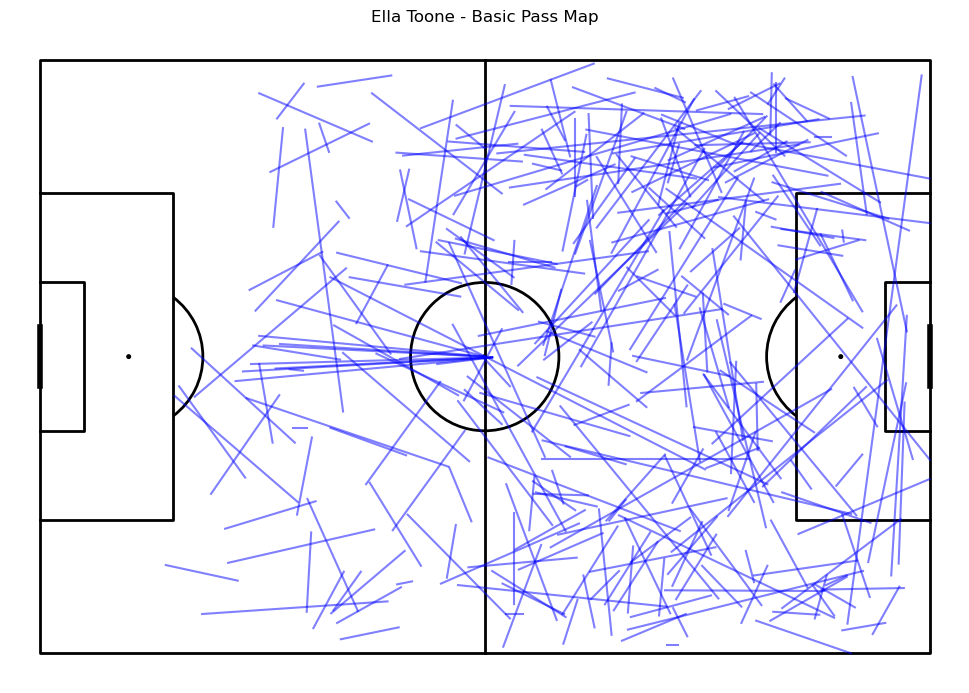

In [8]:
# Basic Pass Map for One Player

def plot_basic_pass_map(player_name, dataset):
    passes = dataset[(dataset['player'] == player_name) & dataset['type'].str.contains('Pass', na=False)]
    
    pitch = Pitch(line_color="black")
    fig, ax = pitch.draw(figsize=(10,7))
    
    for _, thepass in passes.iterrows():
        ax.plot([thepass['start_x'], thepass['end_x']],
                [thepass['start_y'], thepass['end_y']],
                color='blue', alpha=0.5)
    
    ax.set_title(f"{player_name} - Basic Pass Map")
    plt.show()

# Example
plot_basic_pass_map('Ella Toone', euros_all)

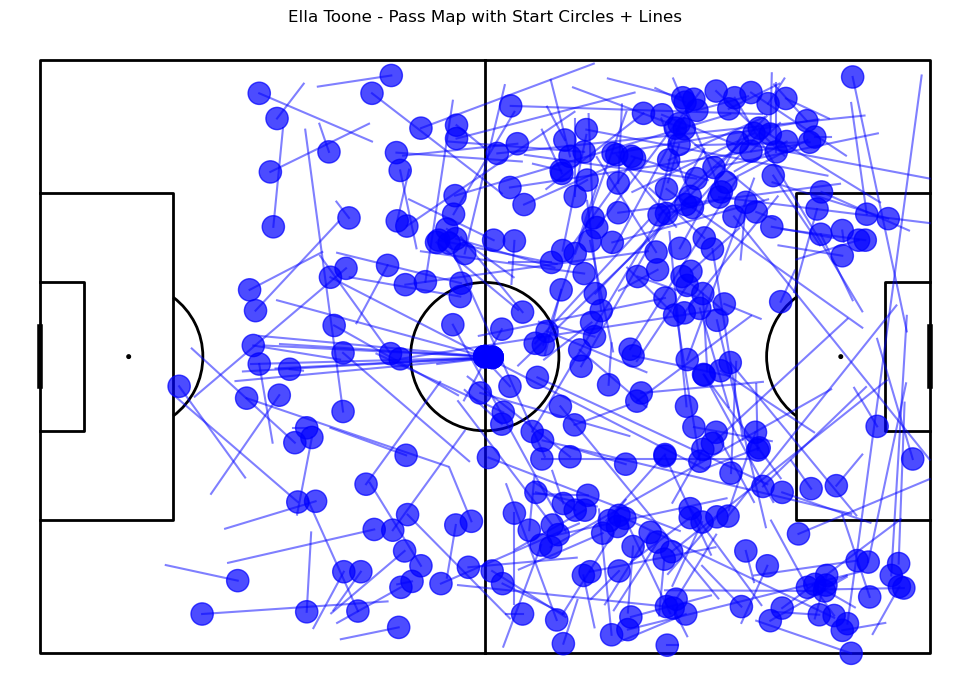

In [10]:
# Add a Circle at Pass Start

import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from mplsoccer import Pitch

def plot_pass_map_with_start_circle_and_line(player_name, dataset):
    passes = dataset[(dataset['player'] == player_name) & dataset['type'].str.contains('Pass', na=False)]
    
    pitch = Pitch(line_color="black")
    fig, ax = pitch.draw(figsize=(10,7))
    
    for _, thepass in passes.iterrows():
        # Circle at pass start
        ax.add_patch(plt.Circle((thepass['start_x'], thepass['start_y']), 1.5, color='blue', alpha=0.7))
        
        # Line from start to end
        ax.plot([thepass['start_x'], thepass['end_x']],
                [thepass['start_y'], thepass['end_y']],
                color='blue', alpha=0.5)
    
    ax.set_title(f"{player_name} - Pass Map with Start Circles + Lines")
    plt.show()

# Example
plot_pass_map_with_start_circle_and_line('Ella Toone', euros_all)

In [13]:
# FUNCTION TO PLOT PLAYER PASSES - final version

def plot_player_pass_map(player_name, dataset, player_stats, competition_label):
    
    # -------------------- Get player position --------------------
    player_row = player_stats[player_stats['player'] == player_name]
    if player_row.empty:
        print(f"Skipping {player_name} — not found in stats")
        return
    
    player_position = player_row['primary_main_position'].dropna().iloc[0].strip().title()

    # -------------------- Position color palettes --------------------
    position_palette = {
        'Goalkeeper': 'royalblue', 
        'Defender':   'limegreen',  
        'Midfielder': '#d18f00',   # darker amber base (better visibility)
        'Forward':    'orangered',   
    }

    light_shade_dict = {
        'Goalkeeper': to_rgb('#7ec8ff'),
        'Defender':   to_rgb('#7dff7d'),
        'Midfielder': to_rgb('#ffd34d'),  # warm yellow (not pale)
        'Forward':    to_rgb('#ff9a76'),
    }

    if player_position not in position_palette:
        print(f"Warning: {player_name} position '{player_position}' not in palette")
    
    base_color = position_palette.get(player_position, 'grey')
    rgb = to_rgb(base_color)
    light_rgb = light_shade_dict.get(player_position, (0.8, 0.8, 0.8))
    dark_rgb = tuple(c * 0.5 for c in rgb)

    position_cmap = LinearSegmentedColormap.from_list(
        f"{player_position}_gradient",
        [dark_rgb, light_rgb]
    )

    # -------------------- Filter passes --------------------
    passes = dataset[
        (dataset['player'] == player_name) &
        dataset['type'].str.contains('Pass', na=False)
    ].dropna(subset=['start_x', 'start_y', 'end_x', 'end_y', 'xP', 'completed'])

    if passes.empty:
        print(f"No passes found for {player_name}")
        return

    norm = Normalize(vmin=0, vmax=1)

    # -------------------- Create pitch --------------------
    pitch = Pitch(line_color="black")
    fig, ax = pitch.draw(figsize=(10, 7))

    # -------------------- Plot passes --------------------
    for _, thepass in passes.iterrows():
        x, y = thepass['start_x'], thepass['start_y']
        dx = thepass['end_x'] - x
        dy = thepass['end_y'] - y
        
        color = position_cmap(norm(thepass['xP']))
        
        ax.add_patch(plt.Circle((x, y), 1.5, color=color, alpha=0.7))
        
        arrow = FancyArrowPatch(
            (x, y), (x + dx, y + dy),
            color=color,
            arrowstyle='-|>',
            linewidth=2,
            alpha=0.9,
            mutation_scale=20,
            linestyle='--' if not thepass['completed'] else '-'
        )
        ax.add_patch(arrow)

    # -------------------- Title --------------------
    ax.set_title(
    f"{player_name} ({player_position}) - Passes in {competition_label}",
    fontsize=18,
    pad=25   # increase this number to move title higher
    )


    # -------------------- Colorbar --------------------
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.05)

    pos = cax.get_position()
    new_height = pos.height * 0.6
    new_y0 = pos.y0 + (pos.height - new_height) / 2
    cax.set_position([pos.x0, new_y0, pos.width, new_height])

    sm = plt.cm.ScalarMappable(cmap=position_cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cax)
    cbar.set_label('xP of Pass', fontsize=12)

    plt.show()



# MASTER LOOP FUNCTION

def plot_multiple_players(players, competition="euros"):
    
    if competition.lower() == "euros":
        dataset = euros_all
        stats = player_stats_euros
        label = "UEFA Women's Euros"
        
    elif competition.lower() == "worldcup":
        dataset = worldcup_all
        stats = player_stats_worldcup
        label = "FIFA Women's World Cups"
        
    else:
        raise ValueError("competition must be 'euros' or 'worldcup'")

    for player in players:
        print(f"Plotting {player}...")
        plot_player_pass_map(player, dataset, stats, label)

Plotting Alessia Russo...


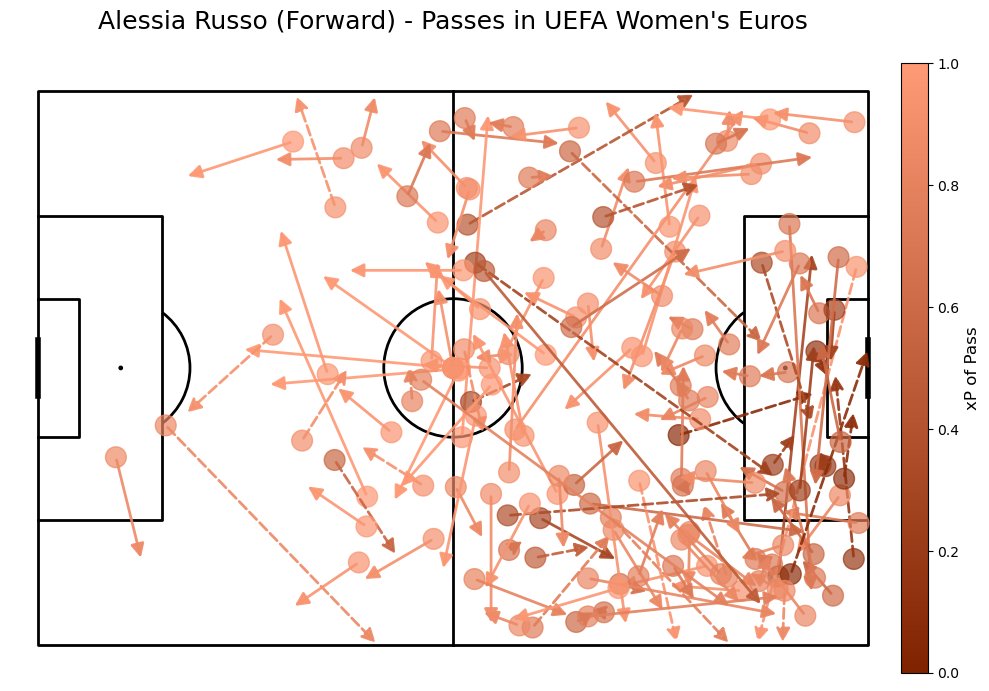

Plotting Ella Toone...


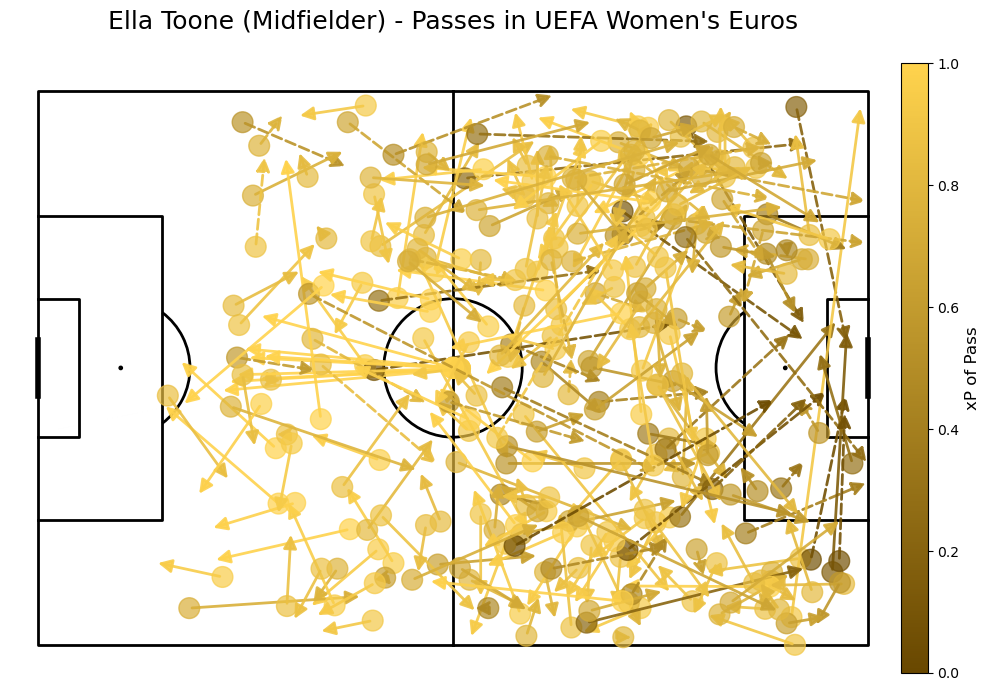

Plotting Olga  Carmona García...


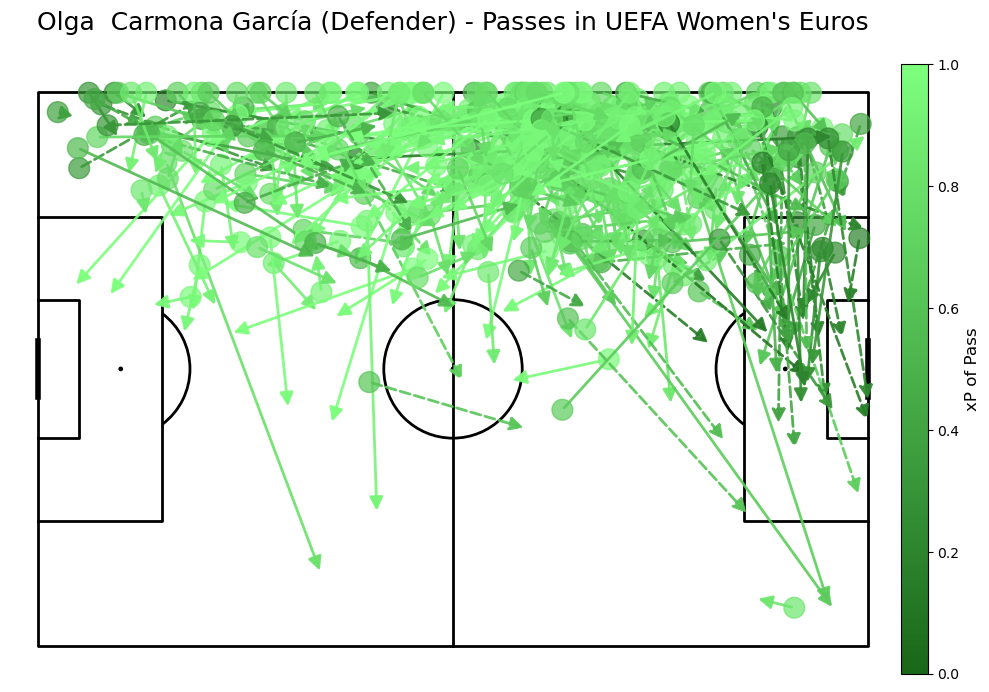

Plotting Hannah Hampton...


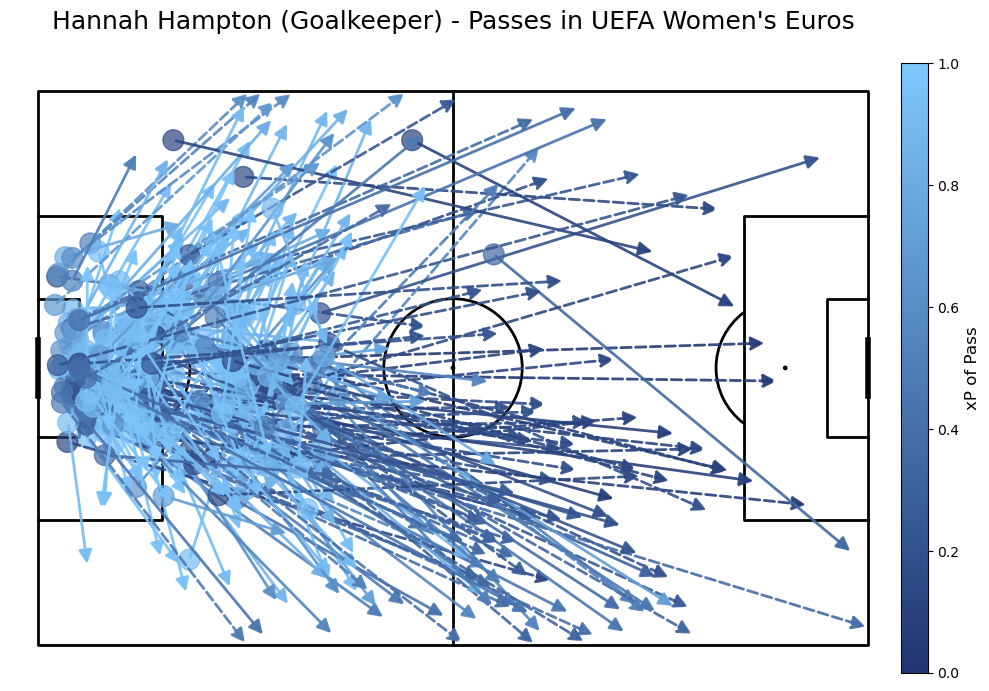

In [14]:
players_to_plot = [
    'Alessia Russo',
    'Ella Toone',
    'Olga  Carmona García',	
    'Hannah Hampton'
]

plot_multiple_players(players_to_plot, competition="euros")